In [87]:
from Functions import PlotFunctions
from Functions import General

import time
from tqdm import tqdm
import pandas as pd
from datetime import datetime
import os
from bs4 import BeautifulSoup
from pdb import set_trace
import quandl
from time import mktime

import numpy as np
path='c:\\Users\\15764\\Documents\\Datasets\\intraQuarter\\'

%matplotlib notebook

style.use('ggplot')

In [80]:
#need to extract only axusition

In [81]:
def GetStats(gather = 'Total Debt/Equity (mrq)',path='', limit = None):
    
    #INIT Data##################
    columns = ['Date',
                'Unix',
                'Ticker',
                gather,
                'Stock Price',
                'Stock Change',
                'SNP500 Value',
                'SNP500 Change',
              'YtY Stock Price Change',
              'YtY SNP500 Value Change',
              'Absolute Stock Perfomance',
              'YtY Stock Perfomance',
              'Absolute Difference',
              'YtY Difference', 
              'Status'] #is the stack is overperform or outperfrorm
    
    print(gather,' of SNP 500 Stocks')
    stock_files = path+ '_KeyStats'
    stock_list = [x[0] for x in os.walk(stock_files)]
    df = pd.DataFrame(columns=columns)
    snp500 = pd.read_csv(r'c:\Users\15764\Documents\Datasets\intraQuarter\YAHOO-INDEX_GSPC.csv', index_col=0 )
    #print(stacks_list)
    amount_of_files = len(stock_list[1:])
    if limit:
        print("Limit set to:", limit)
    else:
        print("Will Crowl All dataset")
    counter = -1
    
    ##################
    
    #Go through Each Ticker (folder)
    for each_dir in tqdm(stock_list[1:]):
        counter +=1
        if limit==counter:
            break
        
        ticker = each_dir.split('\\')[-1]
        print('Start working with: ',ticker)
        each_file = os.listdir(each_dir)
        starting_stock_value = False
        starting_sp_500_value = False
        
        if len(each_file)>0:
            #Get all historic data 
            for file in tqdm(each_file):
                
                date_stamp = datetime.strptime(file,'%Y%m%d%H%M%S.html')
                unix_time = time.mktime(date_stamp.timetuple())
                full_path_file = each_dir +'\\'+file
                with open(full_path_file,'r') as f:
                    source =f.read()
                soup = BeautifulSoup(source, 'html.parser')
                data = []
                rows = soup.find_all('tr')
                for row in rows:
                    cols = row.find_all('td')
                    data.extend([cell.text for cell in cols])
                try:
                    #set_trace()
                    try:
                        value = float(data[data.index(gather+':')+1])
                    except Exception as e: 
                        value = -99999.0
                    
                    try:
                        snp500_data = datetime.fromtimestamp(unix_time).strftime('%Y-%m-%d')
                        row = snp500[snp500.index==snp500_data]
                        snp500_value = float(row['Adj Close'])
                    except:
                        snp500_data = datetime.fromtimestamp(unix_time-259200).strftime('%Y-%m-%d')
                        row = snp500[snp500.index==snp500_data]
                        snp500_value = float(row['Adj Close'])
                
                    
                    
                    
                    #Get data from SNP 500
                    stock_price = quandl_stocks_host_price(symbol=ticker,date=snp500_data)
                    if not starting_stock_value:
                        starting_stock_value = stock_price
                        
                    if not starting_sp_500_value:
                        starting_sp_500_value = snp500_value
                        
                    stock_change = 100*(stock_price -starting_stock_value) / starting_stock_value
                    snp500_change = 100*(snp500_value - starting_sp_500_value) / starting_sp_500_value
                   # print(stock_price)
                        df = df.append({'Date':date_stamp, #'Data'
                                        'Unix':unix_time, #'Unix',
                                        'Ticker':ticker, #'Ticker',
                                        gather:value,# gather,
                                        'Stock Price':stock_price, #'Stock Price',
                                        'Stock Change': stock_change, #'Stock % Change',
                                        'SNP500 Value':snp500_value, #'SNP500 Value',
                                        'SNP500 Change': snp500_change,#'SNP500 % Cnange',

                except Exception as e:
                    pass
    df = df.reset_index()
    #set_trace()
    def ytypchange(row):
        #set_trace()
        if row[columns[0]] == df.loc[0,columns[0]]:
            return 0
        else:
            return 100*(df.loc[row['index'],'Stock Price'] -df.loc[row['index']-1,'Stock Price']) / df.loc[row['index']-1,'Stock Price']
    def ytysnpchange(row):
        if row[columns[0]] == df.loc[0,columns[0]]:
            return 0
        else:
            return 100 *(df.loc[row['index'],'SNP500 Value'] -df.loc[row['index']-1,'SNP500 Value']) / df.loc[row['index']-1,'SNP500 Value']
    
    def calctabsperf(row):
        if row[columns[5]] - row[columns[7]] > 0:
            return 1
        else:
            return 0

    def calcttytperf(row):
        if row[columns[8]] - row[columns[9]] > 0:
            return 1
        else:
            return 0
    
    ytypchange_data = df.apply(ytypchange,axis=1) #'YtY Stock Price Change',
    ytysnpchange_data = df.apply(ytysnpchange,axis=1) #'YtY SNP500 Value Change'
    
    
    calctabsperf_data = df.apply(calctabsperf,axis=1) #'Absolute Stock Perfomance',
    calcttytperf_data = df.apply(calcttytperf,axis=1) #'YtY Stock Perfomance'
    abs_difference_data = df.apply(lambda x : x[columns[5]]-x[columns[7]],axis=1)#'Absolute Difference'
    YtYDifference = df.apply(lambda x : x[columns[8]]-x[columns[9]],axis=1)#'YtY Difference'
    Status = np.where((stock_change - snp500_change) >0,1,0) #1 - outperform, 0 - ounderperform
    
    df = df.append({'Date':date_stamp, #'Data'
                    'Unix':unix_time, #'Unix',
                    'Ticker':ticker, #'Ticker',
                    gather:value,# gather,
                    'Stock Price':stock_price, #'Stock Price',
                    'Stock Change': stock_change, #'Stock % Change',
                    'SNP500 Value':snp500_value, #'SNP500 Value',
                    'SNP500 Change': snp500_change,#'SNP500 % Cnange',
                    'YtY Stock Price Change':ytypchange_data,
                    'YtY SNP500 Value Change' :ytysnpchange_data,
                    'Absolute Stock Perfomance':calctabsperf_data,
                    'Absolute Difference':abs_difference_data,
                    'YtY Difference': YtYDifference,
                    'Status': Status
                   }
                   
                   
                ,ignore_index=True) #'SNP500 Change',
    
    
    
    df.drop('index',axis=1,inplace=True)
    save = gather.replace(' ','').replace('(','').replace(')','').replace('/','')+('.csv')
    print('Will save to file: ',save)
    df.to_csv(save,index=False)
    return df

def create__feature_df():
    pass




In [82]:
df = Key_stats(path=path,limit=20)

Total Debt/Equity (mrq)  of SNP 500 Stocks
Limit set to: 20


  0%|                                                                                          | 0/560 [00:00<?, ?it/s]

Start working with:  a



  0%|▏                                                                               | 1/560 [00:07<1:08:45,  7.38s/it]

Start working with:  aa



  0%|▎                                                                               | 2/560 [00:18<1:23:59,  9.03s/it]

Start working with:  aapl



  1%|▍                                                                               | 3/560 [00:32<1:39:08, 10.68s/it]

Start working with:  abbv



  1%|▌                                                                               | 4/560 [00:32<1:15:06,  8.10s/it]

Start working with:  abc



  1%|▋                                                                               | 5/560 [00:37<1:09:41,  7.53s/it]

Start working with:  abt



  1%|▊                                                                               | 6/560 [00:45<1:10:44,  7.66s/it]

Start working with:  ace



  1%|█                                                                               | 7/560 [00:49<1:05:33,  7.11s/it]

Start working with:  aci



  1%|█▏                                                                              | 8/560 [00:55<1:03:25,  6.89s/it]

Start working with:  acn



  2%|█▎                                                                              | 9/560 [01:03<1:04:55,  7.07s/it]

Start working with:  act



  2%|█▍                                                                               | 10/560 [01:03<58:31,  6.39s/it]

Start working with:  adbe



  2%|█▌                                                                             | 11/560 [01:13<1:01:25,  6.71s/it]

Start working with:  adi



  2%|█▋                                                                             | 12/560 [01:21<1:01:40,  6.75s/it]

Start working with:  adm



  2%|█▊                                                                             | 13/560 [01:35<1:06:53,  7.34s/it]

Start working with:  adp



  2%|█▉                                                                             | 14/560 [01:42<1:06:27,  7.30s/it]

Start working with:  adsk



  3%|██                                                                             | 15/560 [01:48<1:05:29,  7.21s/it]

Start working with:  adt



  3%|██▎                                                                            | 16/560 [01:48<1:01:40,  6.80s/it]

Start working with:  aee



  3%|██▍                                                                            | 17/560 [01:53<1:00:15,  6.66s/it]

Start working with:  aeo



  3%|██▌                                                                              | 18/560 [01:57<58:52,  6.52s/it]

Start working with:  aep



  3%|██▋                                                                              | 19/560 [02:00<57:04,  6.33s/it]

Start working with:  aes



  4%|██▉                                                                              | 20/560 [02:04<56:01,  6.23s/it]


Will save to file:  TotalDebtEquitymrq.csv
elapsed 124.75379514694214


<IPython.core.display.Javascript object>


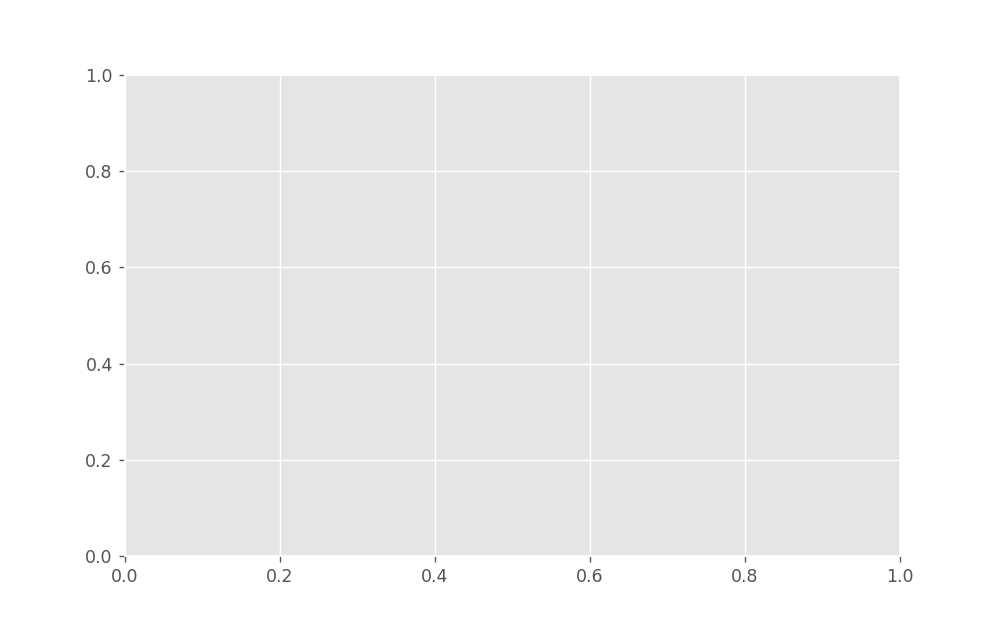

In [83]:
plot_df(df)

In [84]:
df.head()

,Date,Unix,Ticker,Total Debt/Equity (mrq),Stock Price,Stock Change,SNP500 Value,SNP500 Change,YtY Stock Price Change,YtY SNP500 Value Change,Absolute Stock Perfomance,YtY Stock Perfomance,Absolute Difference,YtY Difference,Status
0,2013-05-23 20:50:51,1.369360e+09,aes,279.88,11.26693,84.660136,1650.51001,60.267034,"Empty DataFrame Columns: [index, Date, Unix, T...","Empty DataFrame Columns: [index, Date, Unix, T...","Empty DataFrame Columns: [index, Date, Unix, T...",NaN,"Empty DataFrame Columns: [index, Date, Unix, T...","Empty DataFrame Columns: [index, Date, Unix, T...",1
